# Часть 1

## Этап 1

In [136]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_auc_score, qini_auc_score
from causalml.inference.meta import BaseXClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklift.metrics import uplift_auc_score, qini_auc_score
from xgboost import XGBClassifier

from utils import cramers_v, eta_squared

In [137]:
df = pd.read_csv("uplift_fp_data.csv")
df.head(5)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  int64  
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  int64  
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  int64  
 8   treatment        64000 non-null  int64  
 9   target           64000 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 4.9 MB


In [139]:
df.describe()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,1.481969,242.085656,0.551031,0.549719,0.748469,0.502250,1.319609,0.334172,0.146781
std,3.507592,1.544514,256.158608,0.497393,0.497526,0.697936,0.499999,0.678254,0.471704,0.353890
min,1.000000,0.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,64.660000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,6.000000,1.000000,158.110000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,2.000000,325.657500,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
max,12.000000,6.000000,3345.930000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000


В датасете отсутствуют пропуски

## Этап 2

### EDA


#### Распределение целевой переменной между контрольной и тестовой группами

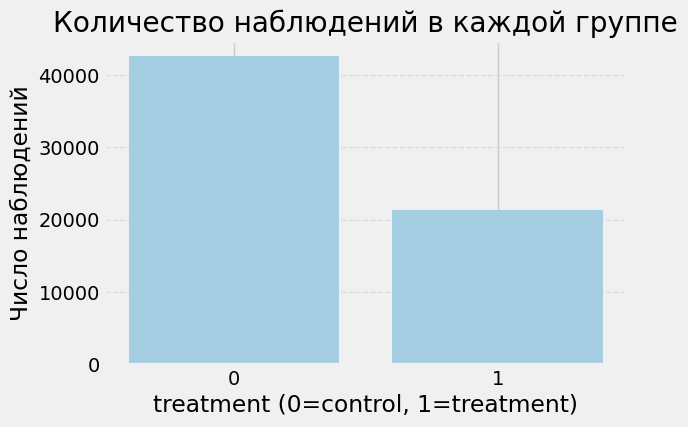

In [140]:
counts = df['treatment'].value_counts().sort_index()
conv_rates = df.groupby('treatment')['target'].mean()

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title('Количество наблюдений в каждой группе')
plt.xlabel('treatment (0=control, 1=treatment)')
plt.ylabel('Число наблюдений')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

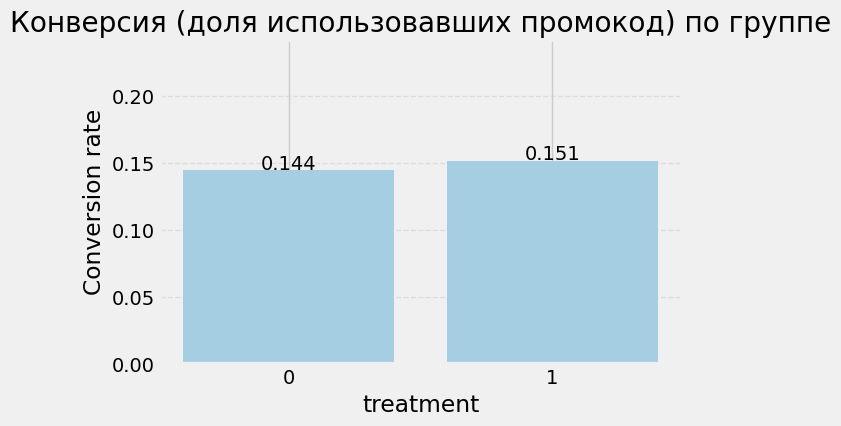

In [141]:
plt.figure(figsize=(6,4))
plt.bar(conv_rates.index.astype(str), conv_rates.values)
plt.title('Конверсия (доля использовавших промокод) по группе')
plt.xlabel('treatment')
plt.ylabel('Conversion rate')
plt.ylim(0, max(conv_rates.values)*1.6)
for i, v in enumerate(conv_rates.values):
    plt.text(i, v+0.001, f"{v:.3f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Выборки несбалансированны, значит S и T модели нам не подходят. Скорее всего будем использовать X или R <br>
Разница в конверсии менее чем в 1 процент. Пока выглядит сомнительно, необходимо провести проверку на статистическую значимость.

## Этап 2

### Проверка на статистическую значимость

**Обоснование:**
- Целевая переменная бинарная (0/1) — сравниваем пропорции двух независимых выборок.
- Подходящий тест: хи-квадрат. Если выборка маленькая, то Фишер.
- Здесь размер выборки большой (n ~ 64k), поэтому chi2 будет корректен.

In [142]:
ct = pd.crosstab(df['treatment'], df['target'])
print('Контингентная таблица (treatment x target):')
print(ct)

Контингентная таблица (treatment x target):
target         0     1
treatment             
0          36457  6156
1          18149  3238


In [143]:
chi2, chi2_p, _, _ = stats.chi2_contingency(ct)
print(f"Chi2 test: chi2={chi2:.4f}, p-value={chi2_p:.4g}")
if chi2_p < 0.05:
    print("Разница между контрольной и тестовой группами статистически значима.")
else:
    print("Разница между контрольной и тестовой группами не статистически значима.")

Chi2 test: chi2=5.4171, p-value=0.01994
Разница между контрольной и тестовой группами статистически значима.


Тест показал, что между группами есть статистически значимые различия. Ура!

### Построение корреляций

Большинство признаков в датасете не имеют порядковой зависимости<br>
Рассчитывать для них корреляцию, как для числовых фичей - странно. <br>
Переведу их к категориальным фичам и рассчитаю eta^2

In [144]:
corr_df = df.copy()
corr_df['history_segment'] = corr_df['history_segment'].astype('category')
corr_df['mens'] = corr_df['mens'].astype('category')
corr_df['womens'] = corr_df['womens'].astype('category')
corr_df['zip_code'] = corr_df['zip_code'].astype('category')
corr_df['newbie'] = corr_df['newbie'].astype('category')
corr_df['channel'] = corr_df['channel'].astype('category')
corr_df['treatment'] = corr_df['treatment'].astype('category')
corr_df['target'] = corr_df['target'].astype('category')

In [145]:
# --- Определяем типы ---
date_cols = corr_df.select_dtypes(include=["datetime", "datetimetz"]).columns.tolist()
num_cols = corr_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in corr_df.columns if c not in num_cols and c not in date_cols]

# Убираем даты
df_corr = corr_df.drop(columns=date_cols, errors="ignore")
cols = df_corr.columns

# --- Строим корреляционную матрицу ---
corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)

for i, col1 in enumerate(cols):
    for j, col2 in enumerate(cols):
        if i > j:
            continue
        if col1 in num_cols and col2 in num_cols:
            corr, _ = stats.spearmanr(df_corr[col1], df_corr[col2], nan_policy='omit')
        elif col1 in cat_cols and col2 in cat_cols:
            corr = cramers_v(df_corr[col1], df_corr[col2])
        elif col1 in num_cols and col2 in cat_cols:
            corr = eta_squared(df_corr[col1], df_corr[col2])
        elif col2 in num_cols and col1 in cat_cols:
            corr = eta_squared(df_corr[col2], df_corr[col1])
        else:
            corr = np.nan
        corr_matrix.loc[col1, col2] = corr
        corr_matrix.loc[col2, col1] = corr

# --- Визуализация ---
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Корреляционная матрица (числовые: Спирман, категориальные: Cramér’s V / Eta²)", fontsize=14)
plt.show()

KeyboardInterrupt: 

Не густо. <br>
Наибольшая корреляция с history_segment, newbie, womens, channel и zip_code

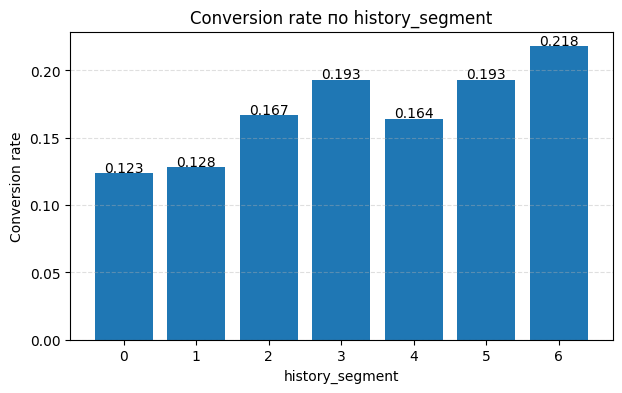

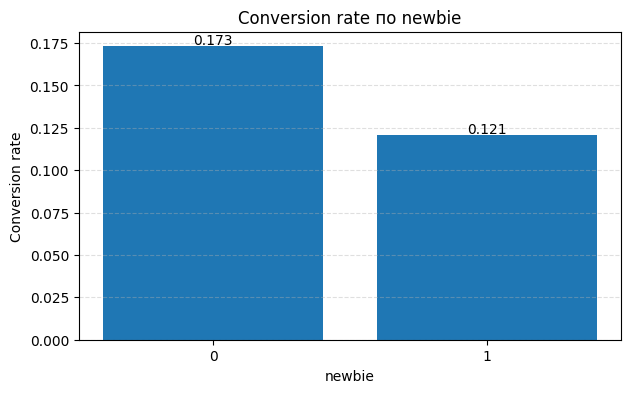

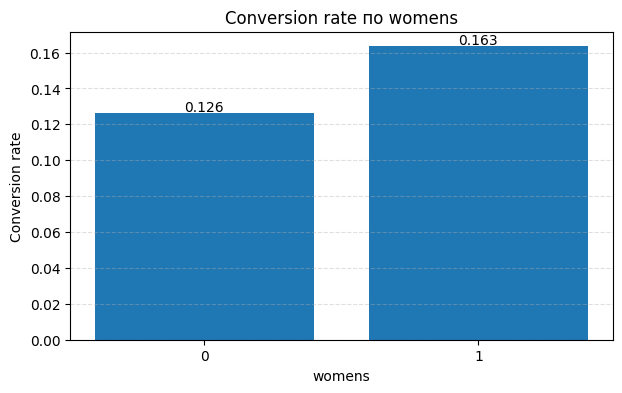

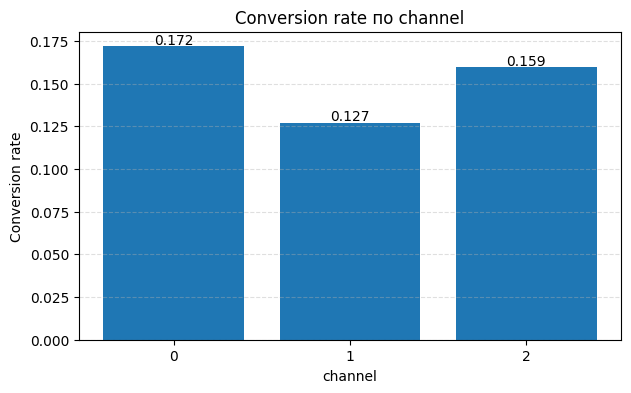

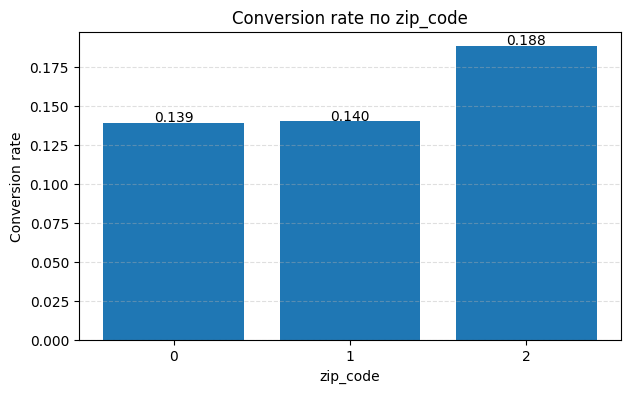

In [ ]:
def plot_conv_hist(features: str):

    conv_df = df.groupby(features)['target'].mean()
    plt.figure(figsize=(7,4))
    plt.bar(conv_df.index.astype(str), conv_df.values)
    plt.title(f'Conversion rate по {features}')
    plt.xlabel(features)
    plt.ylabel('Conversion rate')
    for i,v in enumerate(conv_df.values):
        plt.text(i, v+0.001, f"{v:.3f}", ha='center')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()


main_features = ["history_segment", "newbie", "womens", "channel", "zip_code"]

for features in main_features:
    plot_conv_hist(features)

## Этап 3

В качестве бейзлайна я возьму обычные uplift-деревья. <br>
После я буду обучать X-learner и R-learner т.к. присутствует дисбаланс классов, а эти модели хорошо с ним справляются

### Разбиение выборки на тренировочную и тестовую

In [ ]:
# разделим данные на признаки и целевую переменную
X = df.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = df['target']  # целевая переменная (например, количество поездок)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df[['target', 'treatment']],
                                    random_state=42)

# 1. Разделяем обучающую выборку на treatment=1 и treatment=0
X_treat = X_train[X_train['treatment'] == 1].drop('treatment', axis=1)
y_treat = y_train[X_train['treatment'] == 1]

X_control = X_train[X_train['treatment'] == 0].drop('treatment', axis=1)
y_control = y_train[X_train['treatment'] == 0]

### Обучение выбранного бейзлайна

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# обучим модель RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=6,       
    random_state=42,  
    verbose=1         
)

model.fit(X_train, y_train)

# чтобы оценить uplift-эффекта для каждого пользователя:
# 1. Создаём копию тестовых данных
X_test_treated = X_test.copy()
X_test_control = X_test.copy()

# 2. Устанавливаем значение признака treatment
X_test_treated['treatment'] = 1  # С воздействием
X_test_control['treatment'] = 0  # Без воздействия

# 3. Предсказываем результаты для обоих случаев
y_pred_treated = model.predict_proba(X_test_treated)[:,1]
y_pred_control = model.predict_proba(X_test_control)[:,1]

# 4. Вычисляем uplift как разницу между предсказаниями
uplift = y_pred_treated - y_pred_control

# Добавляем предсказанный uplift к тестовым данным для анализа
X_test['predicted_uplift'] = uplift

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### Расчет метрик для выбранного бейзлайна на тестовой выборке

In [ ]:
# получаем uplift-предсказания для тестовой выборки, также передаём propensity score
uplift_pred = uplift

# оценка метрик uplift
uplift_score = uplift_auc_score(
    y_test.values,
    uplift_pred.squeeze(),
    X_test['treatment'].values
)
qini_score = qini_auc_score(
    y_test.values,
    uplift_pred.squeeze(),
    X_test['treatment'].values
)

u = np.asarray(uplift_pred).squeeze()  # shape (n,)
y = np.asarray(y_test).squeeze()
t = np.asarray(X_test['treatment']).astype(int).squeeze()

# Функция для Uplift@k
def uplift_at_k_manual(y_true, uplift_scores, treatment, k=0.3):
    df = pd.DataFrame({'y': y_true, 'u': uplift_scores, 't': treatment})
    df = df.sort_values('u', ascending=False).reset_index(drop=True)
    topk_n = int(np.ceil(k * len(df)))
    top = df.iloc[:topk_n]
    treated = top[top['t'] == 1]
    control = top[top['t'] == 0]
    r_t = treated['y'].mean() if len(treated) > 0 else 0.0
    r_c = control['y'].mean() if len(control) > 0 else 0.0
    return r_t - r_c, topk_n, len(treated), len(control), r_t, r_c

uplift30_val, topn, nt, nc, rt, rc = uplift_at_k_manual(y, u, t, k=0.3)

print(f"Uplift@30%: {uplift30_val:.6f} (topN={topn}, treated_in_topN={nt}, control_in_topN={nc})")
print(f" - response treated in top30% = {rt:.4f}, control in top30% = {rc:.4f}")
print(f"Uplift AUC (AUUC): {uplift_score:.6f}")
print(f"Qini AUC: {qini_score:.6f}")


Uplift@30%: 0.038237 (topN=3840, treated_in_topN=1278, control_in_topN=2562)
 - response treated in top30% = 0.1604, control in top30% = 0.1222
Uplift AUC (AUUC): 0.027228
Qini AUC: 0.060462


# Обучение 2 моделей 

### Обучение модели 1

Попрбую обучить R-learn

In [ ]:
# разделим данные на признаки и целевую переменную
X = df.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = df['target']  # целевая переменная (например, количество поездок)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df[['target', 'treatment']],
                                    random_state=42)

# 1. Разделяем обучающую выборку на treatment=1 и treatment=0
X_treat = X_train[X_train['treatment'] == 1].drop('treatment', axis=1)
y_treat = y_train[X_train['treatment'] == 1]

X_control = X_train[X_train['treatment'] == 0].drop('treatment', axis=1)
y_control = y_train[X_train['treatment'] == 0]

In [ ]:
import numpy as np
import pandas as pd
from causalml.inference.meta import BaseRClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklift.metrics import uplift_auc_score, qini_auc_score
from sklearn.model_selection import train_test_split

X = df.drop(['target'], axis=1)  
y = df['target']  

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df[['target', 'treatment']],
                                    random_state=42)

features = df.drop(columns=['target','treatment']).columns
T = X_train.treatment.values  # 1 - treatment, 0 - control
X_train = X_train[features]
y_train = y_train.values  # целевая переменная
T_test = X_test.treatment.values


# инициализируем R-learner с моделями XGBoost
# outcome_learner — модель для предсказания исхода без учёта воздействия
# effect_learner — модель для оценки эффекта воздействия
# propensity_learner — модель для оценки вероятности получения воздействия
r_learner = BaseRClassifier(
    outcome_learner=XGBClassifier(
        n_estimators=200,
        learning_rate=0.02,
        max_depth=6,
        random_state=42,
        verbosity=0
    ),
    effect_learner=XGBRegressor(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=6,
        random_state=42,
        verbosity=0
    ),
    propensity_learner=XGBClassifier(
        n_estimators=200,
        learning_rate=0.02,
        max_depth=6,
        random_state=42,
        verbosity=0
    )
)

# инициализируем массив для propensity score
e_x = np.zeros(len(X_train))
T_test = X_test.treatment.values

# обучаем модель для оценки propensity score
model_e = XGBClassifier(n_estimators=100, 
                        learning_rate=0.02, 
                        max_depth=3, 
                        random_state=42, 
                        verbosity=0)
model_e.fit(X_train, T)
e_x = model_e.predict_proba(X_train)[:, 1]

# обучаем модель R-learner
r_learner.fit(
    X=X_train,
    treatment=T,
    y=y_train,
    p=e_x,
    verbose=True
)


### Получение метрик по модели 1

In [ ]:
# получаем оценки uplift-эффекта для тестовой выборки
uplift_scores = r_learner.predict(X_test.drop(columns=['treatment']).values)

# рассчитываем метрики качества модели
uplift_auc = uplift_auc_score(y_test, uplift_scores.squeeze(), T_test)
qini_auc = qini_auc_score(y_test, uplift_scores.squeeze(), T_test)

# Функция для расчета Uplift@k
def uplift_at_k_manual(y_true, uplift_scores, treatment, k=0.3):
    df = pd.DataFrame({'y': y_true, 'u': uplift_scores.squeeze(), 't': treatment})
    df = df.sort_values('u', ascending=False).reset_index(drop=True)
    topk_n = int(np.ceil(k * len(df)))
    top = df.iloc[:topk_n]
    treated = top[top['t'] == 1]
    control = top[top['t'] == 0]
    r_t = treated['y'].mean() if len(treated) > 0 else 0.0
    r_c = control['y'].mean() if len(control) > 0 else 0.0
    return r_t - r_c

# Расчет Uplift@30%
uplift_at_30 = uplift_at_k_manual(y_test, uplift_scores, T_test, k=0.3)

print(f"R-learner Uplift@30%: {uplift_at_30:.4f}")
print(f"R-learner Uplift AUC: {uplift_auc:.5f}")
print(f"R-learner Qini AUC: {qini_auc:.5f}")

R-learner Uplift@30%: 0.0419
R-learner Uplift AUC: 0.02828
R-learner Qini AUC: 0.06354


### Обучение модели 2

Обучаю X-модель

In [ ]:
# разделим данные на признаки и целевую переменную
X = df.drop(['target'], axis=1)  # все столбцы, кроме целевой переменной
y = df['target']  # целевая переменная (например, количество поездок)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    stratify=df[['target', 'treatment']],
                                    random_state=42)

# 1. Разделяем обучающую выборку на treatment=1 и treatment=0
X_treat = X_train[X_train['treatment'] == 1].drop('treatment', axis=1)
y_treat = y_train[X_train['treatment'] == 1]

X_control = X_train[X_train['treatment'] == 0].drop('treatment', axis=1)
y_control = y_train[X_train['treatment'] == 0]

In [ ]:
# используем Random Forest для outcome- и effect-моделей
rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    n_jobs=-1,
    verbose=0
)
rf_reg = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    n_jobs=-1,
    verbose=0
)

# для propensity score используем XGBoost
propensity_model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=0
)
propensity_model.fit(X_train.drop('treatment', axis=1).values, X_train['treatment'].values)
# получаем propensity score для train и test
p_train = propensity_model.predict_proba(X_train.drop('treatment', axis=1).values)[:, 1]
p_test = propensity_model.predict_proba(X_test.drop('treatment', axis=1).values)[:, 1]

x_learner = BaseXClassifier(
    outcome_learner=rf_clf,
    control_name=0,
    effect_learner=rf_reg,
)

# обучаем X-learner с передачей propensity score
x_learner.fit(
    X=X_train.drop('treatment', axis=1).values,
    treatment=X_train['treatment'].values,
    y=y_train.values,
    p=p_train
)

### Получение метрик по модели 2

In [ ]:
# получаем uplift-предсказания для тестовой выборки, также передаём propensity score
uplift_pred = uplift_pred = x_learner.predict(
    X_test.drop('treatment', axis=1).values,
    p=p_test
)

# оценка метрик uplift
uplift_score = uplift_auc_score(
    y_test.values,
    uplift_pred.squeeze(),
    X_test['treatment'].values
)
qini_score = qini_auc_score(
    y_test.values,
    uplift_pred.squeeze(),
    X_test['treatment'].values
)

u = np.asarray(uplift_pred).squeeze()  # shape (n,)
y = np.asarray(y_test).squeeze()
t = np.asarray(X_test['treatment']).astype(int).squeeze()

# Функция для Uplift@k
def uplift_at_k_manual(y_true, uplift_scores, treatment, k=0.3):
    df = pd.DataFrame({'y': y_true, 'u': uplift_scores, 't': treatment})
    df = df.sort_values('u', ascending=False).reset_index(drop=True)
    topk_n = int(np.ceil(k * len(df)))
    top = df.iloc[:topk_n]
    treated = top[top['t'] == 1]
    control = top[top['t'] == 0]
    r_t = treated['y'].mean() if len(treated) > 0 else 0.0
    r_c = control['y'].mean() if len(control) > 0 else 0.0
    return r_t - r_c, topk_n, len(treated), len(control), r_t, r_c

uplift30_val, topn, nt, nc, rt, rc = uplift_at_k_manual(y, u, t, k=0.3)

print(f"Uplift@30%: {uplift30_val:.6f} (topN={topn}, treated_in_topN={nt}, control_in_topN={nc})")
print(f" - response treated in top30% = {rt:.4f}, control in top30% = {rc:.4f}")
print(f"Uplift AUC (AUUC): {uplift_score:.6f}")
print(f"Qini AUC: {qini_score:.6f}")


Uplift@30%: 0.048909 (topN=3840, treated_in_topN=1292, control_in_topN=2548)
 - response treated in top30% = 0.1772, control in top30% = 0.1283
Uplift AUC (AUUC): 0.031002
Qini AUC: 0.069690


X-learner показал лучшие результаты по трём метрикам <br>
X-learner и R-learner показывают результаты лучше, чем решающие деревья, т.к. они заточены под работу с несбалансированными выборками

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

### Подбор гиперпараметров

In [ ]:
import optuna
from causalml.inference.meta import BaseXClassifier
from sklift.metrics import uplift_at_k
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier


def objective(trial):
    # Ускоренные гиперпараметры для пробного запуска
    n_estimators_clf = trial.suggest_int('n_estimators_clf', 100, 200, step=20)
    max_depth_clf = trial.suggest_int('max_depth_clf', 5, 15)
    min_samples_leaf_clf = trial.suggest_int('min_samples_leaf_clf', 2, 10)

    n_estimators_reg = trial.suggest_int('n_estimators_reg', 100, 200, step=20)
    max_depth_reg = trial.suggest_int('max_depth_reg', 5, 15)
    min_samples_leaf_reg = trial.suggest_int('min_samples_leaf_reg', 2, 10)

    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2)

    # Создаем модели
    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators_clf,
        max_depth=max_depth_clf,
        min_samples_leaf=min_samples_leaf_clf,
        n_jobs=-1,
        random_state=42
    )

    rf_reg = RandomForestRegressor(
        n_estimators=n_estimators_reg,
        max_depth=max_depth_reg,
        min_samples_leaf=min_samples_leaf_reg,
        n_jobs=-1,
        random_state=42
    )

    xgb_prop = XGBClassifier(
        n_estimators=50,  # ускоряем обучение
        max_depth=3,
        learning_rate=learning_rate,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        verbosity=0,
        random_state=42
    )

    # Обучаем propensity model
    xgb_prop.fit(X_train.drop('treatment', axis=1).values, X_train['treatment'].values)
    p_train = xgb_prop.predict_proba(X_train.drop('treatment', axis=1).values)[:, 1]
    p_test = xgb_prop.predict_proba(X_test.drop('treatment', axis=1).values)[:, 1]

    # Обучаем X-learner
    x_learner = BaseXClassifier(
        outcome_learner=rf_clf,
        effect_learner=rf_reg,
        control_name=0
    )
    x_learner.fit(
        X=X_train.drop('treatment', axis=1).values,
        treatment=X_train['treatment'].values,
        y=y_train.values,
        p=p_train
    )

    # Предсказания uplift
    uplift_pred = x_learner.predict(X_test.drop('treatment', axis=1).values, p=p_test)
    treatment_test = X_test['treatment'].values

    # Вычисляем uplift_at_k с защитой от NaN
    try:
        score = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')
        if score is None or score != score:  # проверка на NaN
            return float('-inf')
        return score
    except Exception:
        return float('-inf')

# Создаем и запускаем исследование
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)


[I 2025-11-01 20:37:04,805] A new study created in memory with name: no-name-dc42ba5f-68ef-44db-90a8-a62b96aaf409


## Этап 2

### Визуализация результатов

In [ ]:
from utils import custom_uplift_by_percentile

В данной ячейке сделайте вывод о качестве работы модели и проинтерпретируйте график `uplift by percentile` 

# Этап 3

In [ ]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.feature_names = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # реализуйте преобразование данных для модели,
        # если в финальной модели используются новые признаки
       

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)

            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        

        # Дополните код для получения предсказаний аплифта

        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [ ]:
model = UpliftModelInference(model= # ваш код,
                             feature_names= # ваш код)

In [ ]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [ ]:
# проверка работы класса
model.predict(test_data)